In [1]:
## Mount drive
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [2]:
## Imports
import glob
from torchvision import datasets, transforms, models
from PIL import *
import torch
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, sampler
import numpy as np
import os
import time
import cv2
from pathlib import Path
from datetime import datetime
import matplotlib.pyplot as plt
import pandas as pd
from torchvision import models
import sys

In [3]:
RANDOM_SEED = 42
torch.manual_seed(RANDOM_SEED)

In [4]:
## Define paths
parentDir = F"/content/gdrive/My Drive/deep_learning/Project"
imageDir =  'IMAGES/'
path_save_model = F"/content/gdrive/My Drive/deep_learning/Project/models/"
path_save_results =  F"/content/gdrive/My Drive/deep_learning/Project/Results/"
zipped_images_path = '/content/gdrive/My Drive/deep_learning/Project/IMAGES/Zipped/'
zipped_labels_path = '/content/gdrive/My Drive/deep_learning/Project/LABELS/Zipped/'
csv_path = '/content/gdrive/My Drive/deep_learning/Project/final/results/Resultss_2class.csv'

In [14]:
# Define model names to test
model_names = ['model:model_UNET_resnet101,Diff:3,batchSize:16,classes:2,criterion:BCEWithLogitsLoss(),optimizer_name:ADAM_0.0005,Epoch:1.pt']

In [47]:
#Define basic parameters
zipped = 1 #load zipped folders to the current workspace - shortens run time 
trained_on = ['3065', '2985', '3089', '3087', '3091']
validation_set = ['3077']
test_new = 0 ## Get evaluation on new images - this takes a while
show_sample_images = 1 ## 
diff = [3] ## the delta folders that you wish unzip if zipped = 1

In [9]:
## Import our scores and dataset builder
sys.path.append(parentDir)
import Scores as s
import dataset_builder as MyDataset

Load Data

In [48]:
if zipped:
  ## Unzip the zipped image folders
  print('Unzipping images')
  base = Path(zipped_images_path)
  for i in range(1,5):
    print(i)
    zip_path = base/f'IMAGES-20210211T164523Z-00{i}.zip'
    !cp "{zip_path}" .
  !unzip -q IMAGES-20210211T164523Z-001.zip
  !rm IMAGES-20210211T164523Z-001.zip
  !unzip -q IMAGES-20210211T164523Z-002.zip
  !rm IMAGES-20210211T164523Z-002.zip
  !unzip -q IMAGES-20210211T164523Z-003.zip
  !rm IMAGES-20210211T164523Z-003.zip
  !unzip -q IMAGES-20210211T164523Z-004.zip
  !rm IMAGES-20210211T164523Z-004.zip

  if 3 in diff:
    ## Unzip the zipped label folders (diff = 3)
    print('Unzipping labels diff = 3')
    base = Path(zipped_labels_path)
    for i in range(1,4):
      print(i)
      zip_path = base/f'Diff=3-20210212T191543Z-00{i}.zip'
      !cp "{zip_path}" .
    !unzip -q Diff=3-20210212T191543Z-001.zip
    !rm Diff=3-20210212T191543Z-001.zip
    !unzip -q Diff=3-20210212T191543Z-002.zip
    !rm Diff=3-20210212T191543Z-002.zip
    !unzip -q Diff=3-20210212T191543Z-003.zip
    !rm Diff=3-20210212T191543Z-003.zip

    print(os.listdir('/content/Diff=3/'))
    for folder in os.listdir('/content/Diff=3/'):
      dst = folder.split('_')[1]
      print(dst)
      os.rename('/content/Diff=3/' + folder, '/content/Diff=3/'+dst)
  
  if 1 in diff:
    ## Unzip the zipped label folders
    print('Unzipping labels diff = 1')
    base = Path(zipped_labels_path)
    for i in range(1,3):
      print(i)
      zip_path = base/f'Diff=1-20210212T191546Z-00{i}.zip'
      !cp "{zip_path}" .
    !unzip -q Diff=1-20210212T191546Z-001.zip
    !rm Diff=1-20210212T191546Z-001.zip
    !unzip -q Diff=1-20210212T191546Z-002.zip
    !rm Diff=1-20210212T191546Z-002.zip

Unzipping labels diff = 3
1
2
3
['IMG_2985', 'IMG_3065', 'IMG_3091', 'IMG_3089', 'IMG_3087', 'IMG_3077']
2985
3065
3091
3089
3087
3077


Model

In [23]:
!pip install segmentation-models-pytorch
import segmentation_models_pytorch as smp

class HandSegModel(nn.Module):
  def __init__(self, my_pretrained_model):
      super(HandSegModel,self).__init__()
      self.dl = my_pretrained_model
      
  def forward(self, x):
      y = self.dl(x)['out']
      return y

def get_model(model_type, encoder, classes): ##model_UNET_encoder
  # model_type = model_name.split('_')[1]
  # encoder = model_name.split('_')[2]
  # print(model_type, encoder)
  model = []
  if model_type == 'UNET':
    model = smp.Unet(encoder, encoder_weights="imagenet", classes=classes)
  elif model_type == 'deeplabv3' and encoder == 'resnet101':
    model = models.segmentation.deeplabv3_resnet101(pretrained=True)
    model.aux_classifier[4] = nn.Conv2d(256, classes, kernel_size=(1, 1), stride=(1, 1))
    model.classifier[4] = nn.Conv2d(256, classes, kernel_size=(1, 1), stride=(1, 1))
    model = HandSegModel(my_pretrained_model=model)
  return model

Save File

In [12]:
if not os.path.isfile(csv_path):
  print('Creating csv')
  dataset = pd.DataFrame(columns = ['Architecture', 'Model_name', 'pretrained',	'trained_layers',	'diff',	'epochs',
                                    'batchsize',	'num_class',	'optimizer',	'criterion', 'lr_scheduler_op', 'trained on', 
                                    'Train_MSE', 'Train_loss', 'Train_meanIOU', 'Train_pixelAcc', 'Train_dice_score',
                                    'Test_MSE', 'Test_loss', 'Test_meanIOU', 'Test_pixelAcc', 'Test_dice_score','Rest_time',])
  dataset.to_csv(csv_path)#, index = False)

In [13]:
def add_to_csv(Architecture, Model_name, pretrained, trained_layers,
               diff, epochs,	batchsize, num_class,	optimizer,	
               criterion, lr_scheduler_op, trained_on, Train_MSE, 
               Train_loss, Train_meanIOU, Train_pixelAcc, 
               Train_dice_score, Test_MSE, Test_loss, 
               Test_meanIOU, Test_pixelAcc, Test_dice_score,Rest_time):

  dataset = pd.DataFrame({'Architecture': Architecture,
                          'Model_name': Model_name, 
                          'pretrained': pretrained,	
                          'trained_layers': trained_layers,	
                          'diff': diff,	
                          'epochs': epochs,	
                          'batchsize': batchsize,	
                          'num_class': num_class,	
                          'optimizer': optimizer,	
                          'criterion': criterion,	
                          'lr_scheduler_op': lr_scheduler_op, 
                          'trained on': trained_on, 
                          'Train_MSE': Train_MSE, 
                          'Train_loss': Train_loss, 
                          'Train_meanIOU': Train_meanIOU, 
                          'Train_pixelAcc': Train_pixelAcc, 
                          'Train_dice_score': Train_dice_score,
                          'Test_MSE': Test_MSE, 
                          'Test_loss': Test_loss, 
                          'Test_meanIOU': Test_meanIOU, 
                          'Test_pixelAcc': Test_pixelAcc, 
                          'Test_dice_score': Test_dice_score,
                          'Rest_time':Rest_time}, index=[0])
  dataset.to_csv(csv_path, 
                 mode='a', header=False)

Training

In [15]:
## Check if GPU is available
dev = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
use_GPU = True if torch.cuda.is_available() else False

In [16]:
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

In [17]:
def parser(model_name):
  pars = model_name.split('_')
  model_type = pars[1]
  pars2 = pars[2].split(',')
  encoder = pars2[0]
  diff = int(pars2[1].split(':')[1])
  batch_size =  int(pars2[2].split(':')[1])
  classes =  int(pars2[3].split(':')[1])
  criterion =  pars2[4].split(':')[1]
  epoch =  int(pars[4].split(':')[1][0])
  print(model_type, encoder, diff, batch_size, classes, criterion, epoch)
  return model_type, encoder, diff, batch_size, classes, criterion, epoch

In [18]:
def create_loader(diff, classes, batchSize, lis, zipped, train):
  pre = '/content/' if zipped else ''
  maskDir=f'Diff={diff}/' if zipped else f'LABELS/Diff={diff}/'

  for file_name in lis: 
      print(pre + imageDir + file_name, pre + maskDir + file_name if zipped else maskDir + file_name)
      Dataset = MyDataset.MyDataset('' if zipped else parentDir,
                                                                        pre + imageDir + file_name,
                                                                        pre + maskDir + file_name if zipped
                                                                        else maskDir + file_name, classes, diff,
                                                                        zipped)
  loader = DataLoader(Dataset, batch_size=batchSize, shuffle=True if train else False, drop_last=True)
  return loader

In [35]:
def plot_graphs(model_arch, epoch, running_train_loss, running_test_loss_arr, 
                                  meanioutrain, meanioutest_arr, 
                                  pixelacctrain, pixelacctest_arr, 
                                  dicetrain, dicetest_arr, N=1):
  fig, ax = plt.subplots(ncols = 4, nrows = 2, figsize = (20,10))
  ax[0][0].plot(running_mean(running_train_loss, N), 'r.', label='training loss')
  ax[1][0].plot(running_mean(running_test_loss_arr, N), 'b.', label='validation loss')
  ax[0][1].plot(running_mean(meanioutrain, N), 'g.', label='meanIOU training')
  ax[1][1].plot(running_mean(meanioutest_arr, N), 'r.', label='meanIOU validation')
  ax[0][2].plot(running_mean(pixelacctrain, N), 'b.', label='pixelAcc  training')
  ax[1][2].plot(running_mean(pixelacctest_arr, N), 'b.', label='pixelAcc validation')
  ax[0][3].plot(running_mean(dicetrain, N), 'b.', label='Dice  training')
  ax[1][3].plot(running_mean(dicetest_arr, N), 'b.', label='Dice validation')
  for a in ax:
      for f in a:
          f.legend()
          f.grid(True)

  # plt.savefig(path_save_results+model_arch+'_'+str(epoch)+'second_BCELOSS_printevery=700_7.3-test.jpeg')
  plt.show()

In [20]:
def plot_segmentation_comparison(new_image, new_predicted):
  image = new_image[0,1,:,:].cpu().detach().numpy()
  predicted = new_predicted[0,1,:,:].cpu().detach().numpy()
  plt.figure(figsize=(15,15))
  plt.subplot(1,4,1)
  plt.imshow(image)
  plt.axis('off')
  plt.title('Original label')
  plt.subplot(1,4,2)
  plt.imshow(predicted)
  plt.axis('off')
  plt.title('Predicted')
  plt.subplot(1,4,3)
  plt.imshow(predicted > np.mean(predicted))
  plt.axis('off')
  plt.title('Predicted after threshold')
  plt.subplot(1,4,4)
  plt.imshow(image> np.mean(image))
  plt.axis('off')
  plt.title('Original after threshold')
  plt.show()

In [43]:
def make_new_test(model, use_GPU, val_loader, criterion):
  meanioutest = []; pixelacctest = []; dicetest = [];
  MSEtest = []; running_test_loss = [];
  with torch.no_grad():
      val_loss = 0
      model.eval()
      for j, (data, target) in enumerate(val_loader):
          torch.cuda.empty_cache()
          if use_GPU:
            data, target = data.cuda().float(), target.cuda().float()
          output = model(data)
          if str(criterion) == 'MSELoss()':
            loss = criterion(torch.sigmoid(output), target)
          else:
            loss = criterion(output, target)
          output = torch.sigmoid(output)
      
          running_test_loss.append(float(loss.item()))
          meanioutest.append(float(s.meanIOU(target, output)))
          pixelacctest.append(float(s.pixelAcc(target, output)))
          dicetest.append(float(s.dice_score(target, output)))
          MSEtest.append(float(s.MSE(target, output)))
  model.train()
  print('Test evaluation:')
  print('Mean loss:', np.mean(running_test_loss))
  print('Mean IOU:', np.mean(meanioutest))
  print('Mean pixel accuracy:', np.mean(pixelacctest))
  print('Mean Dice:', np.mean(dicetest))
  print('Mean MSE:', np.mean(MSEtest))

In [49]:
test_new =1

UNET resnet101 3 16 2 BCEWithLogitsLoss() 1
Using GPU
/content/IMAGES/3077 /content/Diff=3/3077
['/content/IMAGES/3077/IMG_3077_1.jpeg']
['/content/IMAGES/3077/IMG_3077_2.jpeg']
9078
9078


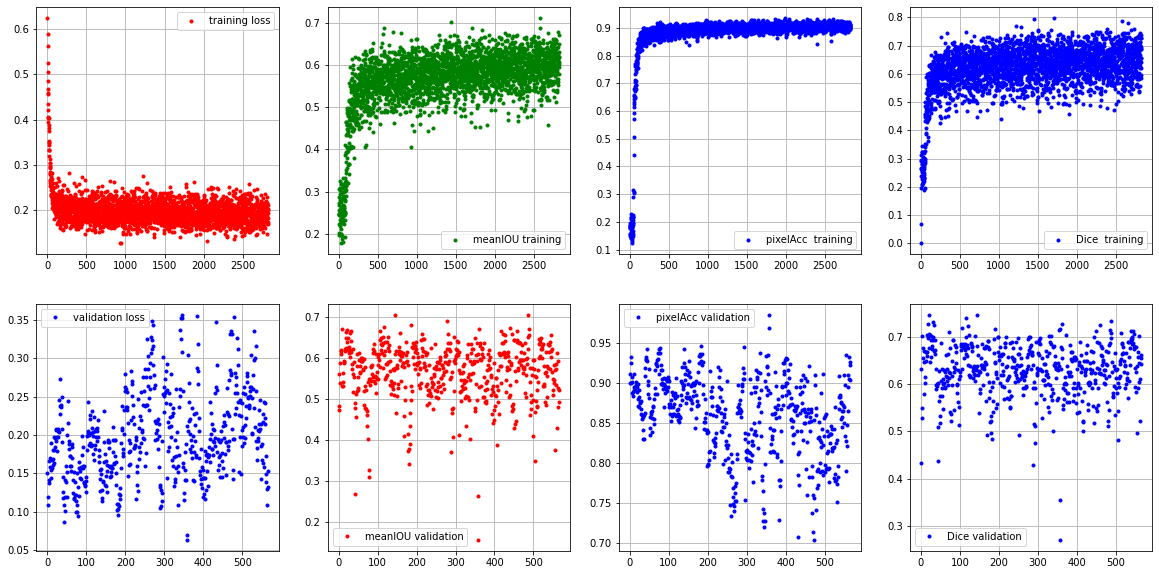

Test evaluation:
Mean loss: 0.19787303274218157
Mean IOU: 0.5410260131896527
Mean pixel accuracy: 0.8313137084718735
Mean Dice: 0.6884204980767803
Mean MSE: 0.006936712502181609


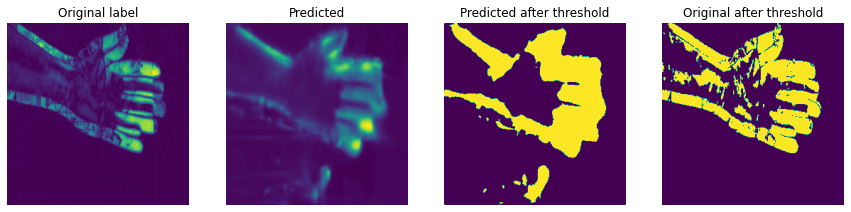

In [51]:
for model_name in model_names:
  model_arch, encoder, diff_i, batch_i, class_i, criterion, epoch = parser(model_name)
  model = get_model(model_arch, encoder, class_i)
  if use_GPU:
      model.to(dev)
      print('Using GPU')
  val_loader = create_loader(diff_i, class_i, batch_i, validation_set, zipped, 0)
  criterion = nn.MSELoss() if criterion == 'MSELoss()' else nn.BCEWithLogitsLoss()
  checkpoint = torch.load(path_save_model+model_name)
  model.load_state_dict(checkpoint['state_dict'])
  running_val_loss = checkpoint['Validation Loss']
  meanioutest = checkpoint['MeanIOU test']
  pixelacctest = checkpoint['PixelAcc test']
  dicetest = checkpoint['Dice test']
  MSEtest = checkpoint['MSE test']
  train_loss = checkpoint['Training Loss']
  meanioutrain = checkpoint['MeanIOU train']
  pixelacctrain = checkpoint['PixelAcc train']
  dicetrain = checkpoint['Dice train']
  MSEtrain = checkpoint['MSE train']
  plot_graphs(model_arch, epoch, train_loss, running_val_loss, 
                                  meanioutrain, meanioutest, 
                                  pixelacctrain, pixelacctest, 
                                  dicetrain, dicetest, N=1)
  if test_new: ## This takes a while
    make_new_test(model, use_GPU, val_loader, criterion)
  if show_sample_images:
    with torch.no_grad():
      model.eval()
      data, target = next(iter(val_loader))
      torch.cuda.empty_cache()
      if use_GPU:
        data, target = data.cuda().float(), target.cuda().float()
      output = model(data)
      if str(criterion) == 'MSELoss()':
        loss = criterion(torch.sigmoid(output), target)
      else:
        loss = criterion(output, target)
      output = torch.sigmoid(output)
    model.train()
    plot_segmentation_comparison(target, output)